In [1]:
from physDBD import ImportHelper, DataDesc, Params0GaussTraj, RxnInputsGaussLayer, \
    DParams0GaussTraj, RxnGaussModel, TrainingGaussData, DataTypeGauss
import numpy as np
import tensorflow as tf
import sys
import os
import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
data_dir = "stochastic_simulations/data/"

# Transformation

## Calculate

In [5]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=0,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

In [6]:
data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

In [6]:
data.shape

(1000, 25, 2)

In [7]:
trans_mean = np.mean(data,axis=(0,1))

print("Means: ", trans_mean)    

Means:  [5567.17804  523.62904]


In [8]:
ds = data.shape
arr = np.reshape(pow(data - trans_mean,2),(ds[0]*ds[1],ds[2]))
length = arr.shape[0]

trans_std = np.sum(list(arr), axis=0) / length
trans_std = np.sqrt(trans_std)

print("Std. devs: ", trans_std)

Std. devs:  [2965.46043848  781.55460313]


## Export

In [9]:
np.savetxt("cache/trans_mean.txt",trans_mean)
np.savetxt("cache/trans_std.txt",trans_std)

## Import

In [10]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Plot

In [11]:
data_desc = DataDesc(
    seed_start_inc=1,
    seed_end_exc=2,
    time_start=0,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

In [12]:
data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

Text(0.5, 0, 'Timepoint (x 0.1s)')

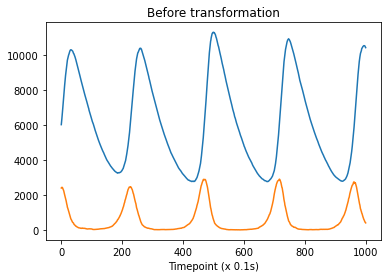

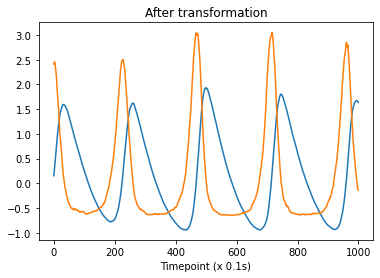

In [13]:
ex_traj = data[:,0]

plt.figure()
plt.plot(ex_traj)
plt.title("Before transformation")
plt.xlabel("Timepoint (x 0.1s)")

plt.figure()
plt.plot((ex_traj - trans_mean)/trans_std)
plt.title("After transformation")
plt.xlabel("Timepoint (x 0.1s)")

## Mean, cov

In [39]:
x = data_trans[:,:,0]
np.cov(x).shape

(1000, 1000)

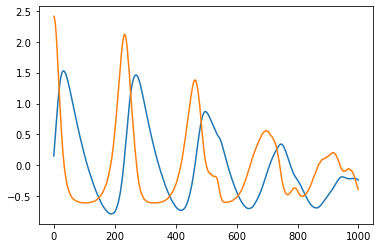

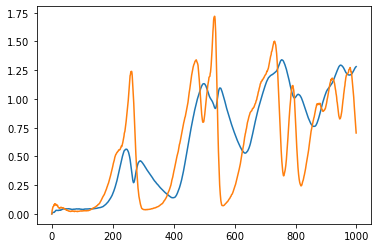

In [40]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=0,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
    )

data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

data_trans = (data - trans_mean)/trans_std

plt.figure()
plt.plot(np.mean(data_trans[:,:,0],axis=1))
plt.plot(np.mean(data_trans[:,:,1],axis=1))

plt.figure()
plt.plot(np.std(data_trans[:,:,0],axis=1))
plt.plot(np.std(data_trans[:,:,1],axis=1))

# Gaussian params

## Import transformation

In [41]:
trans_mean = np.loadtxt("cache/trans_mean.txt")
trans_std = np.loadtxt("cache/trans_std.txt")

## Import, calculate params

In [43]:
data_desc = DataDesc(
    seed_start_inc=0,
    seed_end_exc=25,
    time_start=1,
    time_end=100,
    time_interval=0.1,
    species=["H","P"]
)

In [45]:
data = ImportHelper.import_gillespie_ssa_from_data_desc(
    data_desc=data_desc,
    data_dir=data_dir,
    zero_padding=2
    )

data = (data - trans_mean) / trans_std

# Create params traj and export
params_traj = Params0GaussTraj.fromData(data, data_desc.times)

# Export
params_traj.export("cache/cache_params.txt")

## Plot

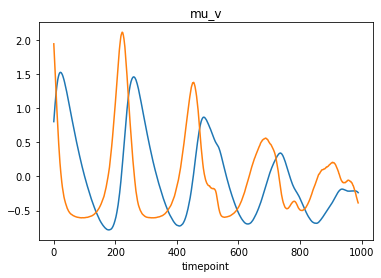

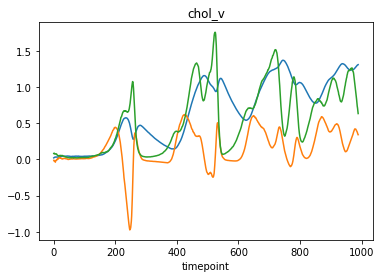

In [46]:
# Import params traj
params_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)

plt.figure()
plt.plot([x.mu_v[0] for x in params_traj.params0_traj])
plt.plot([x.mu_v[1] for x in params_traj.params0_traj])
plt.title("mu_v")
plt.xlabel("timepoint")
plt.savefig("figures/params_mu_v.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params_traj.params0_traj])
plt.plot([x.chol_v[1,0] for x in params_traj.params0_traj])
plt.plot([x.chol_v[1,1] for x in params_traj.params0_traj])
plt.title("chol_v")
plt.xlabel("timepoint")
plt.savefig("figures/params_chol_v.png", dpi=200)

Text(0.5, 0, 'timepoint')

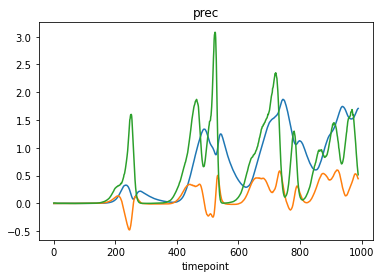

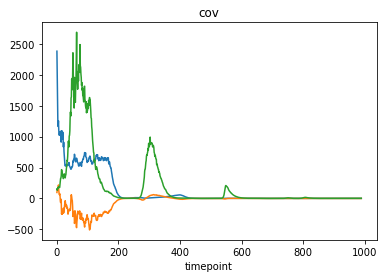

In [48]:
# Ensure cov is still the same
precs = []
covs = []
for params0 in params_traj.params0_traj:
    chol_v = np.array([[params0.chol_v[0,0],0.],[params0.chol_v[1,0],params0.chol_v[1,1]]])
    
    prec = np.dot(chol_v,np.transpose(chol_v))
    precs.append(prec)
    
    cov = np.linalg.inv(prec)
    covs.append(cov)

plt.figure()
plt.plot([prec[0,0] for prec in precs])
plt.plot([prec[1,0] for prec in precs])
plt.plot([prec[1,1] for prec in precs])
plt.title("prec")
plt.xlabel("timepoint")

plt.figure()
plt.plot([cov[0,0] for cov in covs])
plt.plot([cov[1,0] for cov in covs])
plt.plot([cov[1,1] for cov in covs])
plt.title("cov")
plt.xlabel("timepoint")

# Derivatives

In [39]:
alphas = {
    "mu_v_0": 10.0,
    "mu_v_1": 10.0,
    "chol_v_0_0": 10.0,
    "chol_v_1_0": 10.0,
    "chol_v_1_1": 10.0
}
non_zero_vals = list(alphas.keys())

In [40]:
# Import params traj
params0_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)

# Differentiate
dparams0_traj = params0_traj.differentiate_with_TVR(
    alphas=alphas, 
    no_opt_steps=10, 
    non_zero_vals=non_zero_vals
    )

# Export
dparams0_traj.export("cache/cache_derivs.txt")

## Plot

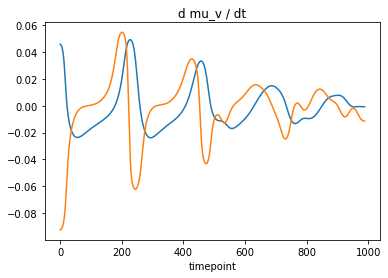

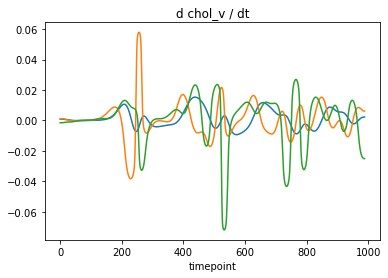

In [41]:
# Import params TE traj
paramsTE_traj = DParams0GaussTraj.fromFile("cache/cache_derivs.txt", nv=2)

plt.figure()
plt.plot([x.dmu_v[0] for x in paramsTE_traj.dparams0_traj])
plt.plot([x.dmu_v[1] for x in paramsTE_traj.dparams0_traj])
plt.title("d mu_v / dt")
plt.xlabel("timepoint")
plt.savefig("figures/derivs_mu_v.png", dpi=200)

plt.figure()
plt.plot([x.dchol_v[0,0] for x in paramsTE_traj.dparams0_traj])
plt.plot([x.dchol_v[1,0] for x in paramsTE_traj.dparams0_traj])
plt.plot([x.dchol_v[1,1] for x in paramsTE_traj.dparams0_traj])
plt.title("d chol_v / dt")
plt.xlabel("timepoint")
plt.savefig("figures/derivs_chol_v.png", dpi=200)

## Re-integrate

In [42]:
# Import params and TE traj
params0_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)
dparams0_traj = DParams0GaussTraj.fromFile("cache/cache_derivs.txt", nv=2)

# Integrate
no_steps = len(params0_traj.params0_traj) - 1
params0_traj_filtered = Params0GaussTraj.fromIntegrating(
    dparams0_traj=dparams0_traj,
    params0_init=params0_traj.params0_traj[0],
    tpt_start=0,
    no_steps=no_steps,
    constant_vals_lf={}
    )

# Export
params0_traj_filtered.export("cache/cache_filtered.txt")

## Plot

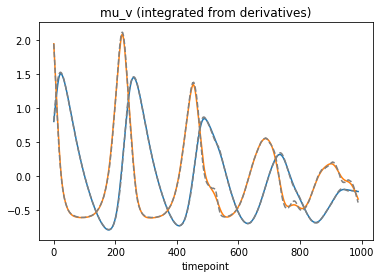

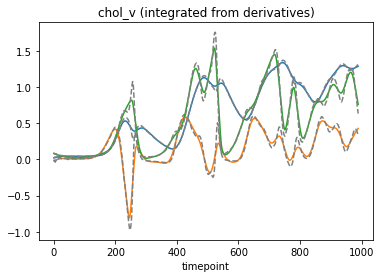

In [43]:
# Import params traj
params0_traj_filtered = Params0GaussTraj.fromFile("cache/cache_filtered.txt", nv=2)
params0_traj = Params0GaussTraj.fromFile("cache/cache_params.txt", nv=2)

plt.figure()
plt.plot([x.mu_v[0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.mu_v[0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.mu_v[1] for x in params0_traj_filtered.params0_traj])
plt.plot([x.mu_v[1] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.title("mu_v (integrated from derivatives)")
plt.xlabel("timepoint")
plt.savefig("figures/filtered_mu_v.png", dpi=200)

plt.figure()
plt.plot([x.chol_v[0,0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[0,0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,0] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[1,0] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.plot([x.chol_v[1,1] for x in params0_traj_filtered.params0_traj])
plt.plot([x.chol_v[1,1] for x in params0_traj.params0_traj], color="gray", linestyle="dashed")
plt.title("chol_v (integrated from derivatives)")
plt.xlabel("timepoint")
plt.savefig("figures/filtered_chol_v.png", dpi=200)